# Import Libraries/Packages

In [1]:
import spectral.io.envi as envi
import glob
import os
import numpy as np
import matplotlib.pyplot as plt
from sklearn import preprocessing
from PIL import Image
from Methods import segment,createKeyPoints,Homography,warp
import cv2
import matplotlib.pyplot as plt
import numpy as np
from spectral import imshow, view_cube
import spectral.io.envi as envi
import os
from sklearn.cluster import KMeans
import ants
import time

# Load the 2 images (fixed image and moving image) and their corresponding masks

Text(0.5, 1.0, 'moving_image')

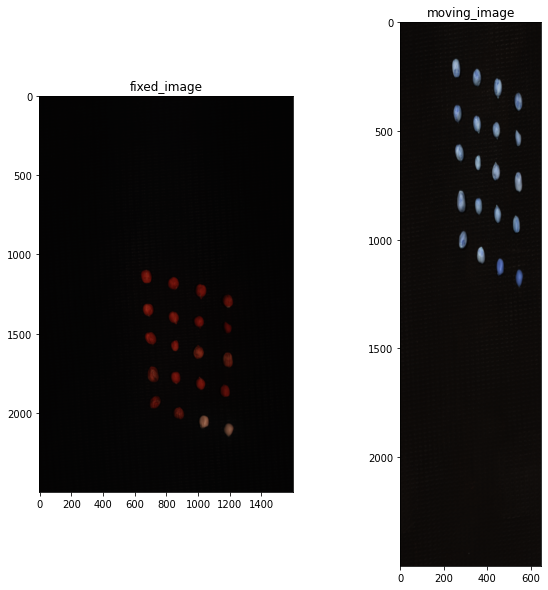

In [2]:
fixed_RGB=cv2.imread('./images/Fixed.png')
moving_RGB=cv2.imread('./images/Moving.png')
fixed_RGB = cv2.cvtColor(fixed_RGB, cv2.COLOR_BGR2RGB)
moving_RGB = cv2.cvtColor(moving_RGB, cv2.COLOR_BGR2RGB)
fig= plt.figure(figsize=(10,10))
# plt.subplot(1,2,figsize=(20,10))
fig.add_subplot(1,2,1)
plt.imshow(fixed_RGB)
plt.title('fixed_image')
fig.add_subplot(1,2,2)
plt.imshow(moving_RGB)
plt.title('moving_image')

# Segment the fixed and moving images
In this problem I am aligning the masks instead of using the RGB images. The variables "mask_f" is the fixed image mask and "mask_m" is the moving image mask. You can think of aligning the masks together as the skeleton model to align the images together later on

Text(0.5, 1.0, 'moving_image_mask')

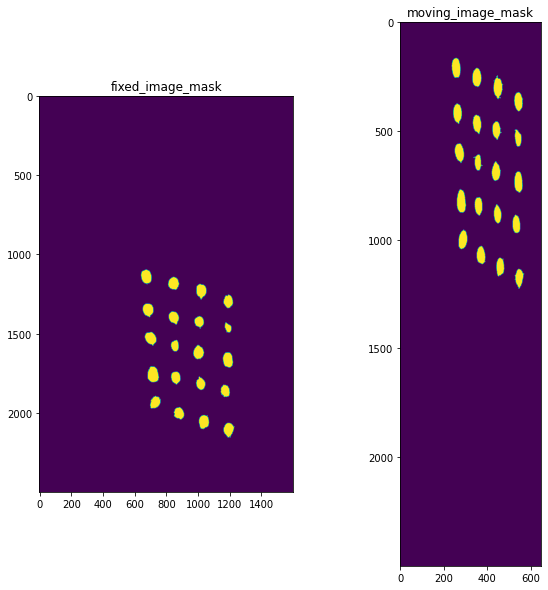

In [3]:
mask_f=segment(fixed_RGB)
mask_m=segment(moving_RGB)
fig= plt.figure(figsize=(10,10))
# plt.subplot(1,2,figsize=(20,10))
fig.add_subplot(1,2,1)
plt.imshow(mask_f)
plt.title('fixed_image_mask')
fig.add_subplot(1,2,2)
plt.imshow(mask_m)
plt.title('moving_image_mask')

# Acquire the keypoints from both images for the image alignment process
I will be using RANdom SAmple Consensus (RANSAC) algorithm to align the images. In my case, I am using the center pixel coordinate of each peanut as my keypoints. First I apply connected component analysis (CCA) on both masks to separate the peanuts. Then, I get the center pixel of each peanut by averaging x-axis and y-axis coordinates of each component/peanut in the mask. Note that the number of keypoints from both images must be the same. In addition to that, each keypoint from the fixed image MUST correspond to the same physical location of the keypoint in the moving image. In this case, each peanut from the fixed image must correspond to the same peanut in the moving image.



In [4]:
output_f = cv2.connectedComponentsWithStats(mask_f.astype(np.uint8), 8, cv2.CV_32S)
(numLabels_f, labels_f, stats_f, centroids_f) = output_f
print('The number of components, which is the number of keypoints as well, in the fixed image =',numLabels_f-1)

output_m = cv2.connectedComponentsWithStats(mask_m.astype(np.uint8), 8, cv2.CV_32S)
(numLabels_m, labels_m, stats_m, centroids_m) = output_m
print('The number of components, which is the number of keypoints as well, in the moving image =',numLabels_f-1)

f_keypoints=createKeyPoints(labels_f)
m_keypoints=createKeyPoints(labels_m)
print(f_keypoints)
print(m_keypoints)

The number of components, which is the number of keypoints as well, in the fixed image = 20
The number of components, which is the number of keypoints as well, in the moving image = 20
[[ 676. 1143.]
 [ 847. 1186.]
 [1021. 1232.]
 [1192. 1299.]
 [ 687. 1352.]
 [ 849. 1400.]
 [1009. 1427.]
 [1190. 1465.]
 [ 703. 1531.]
 [ 856. 1578.]
 [1004. 1620.]
 [1190. 1667.]
 [ 718. 1760.]
 [ 861. 1779.]
 [1018. 1817.]
 [1173. 1863.]
 [ 731. 1935.]
 [ 881. 2003.]
 [1038. 2057.]
 [1194. 2106.]]
[[ 257.  210.]
 [ 352.  254.]
 [ 449.  300.]
 [ 544.  365.]
 [ 264.  418.]
 [ 353.  467.]
 [ 442.  495.]
 [ 542.  533.]
 [ 272.  599.]
 [ 357.  644.]
 [ 440.  687.]
 [ 544.  735.]
 [ 281.  824.]
 [ 360.  844.]
 [ 448.  883.]
 [ 534.  929.]
 [ 288. 1000.]
 [ 371. 1071.]
 [ 460. 1124.]
 [ 547. 1175.]]


# Acquiring the Homography matrix
The homography matrix is a 3x3 matrix that applies rotation, translation, scaling, and projection in order to align the images. The homography method takes in acquired keypoints as inputs. Order of keypoints corresponding to the same physical location matters.

<img src="./homography1.png"/>
<img src="./homography2.png"/>

In [5]:
H=Homography(f_keypoints,m_keypoints)
H

array([[1.81977732e+00, 3.11919312e-03, 2.09919543e+02],
       [9.46285698e-03, 1.01846889e+00, 9.29932076e+02],
       [9.48778261e-06, 5.85074470e-06, 1.00000000e+00]])

# Alignment result of the Homography
Below is showing the alignment result of aligning the moving image on to the fixed image. The alignment process is called "warping." Even though the "fixed_mask" looks exactly like the "alignment_result," if you subtract them from each other, you will see that there is a minor difference.

Text(0.5, 1.0, 'fixed_mask - alignment_result')

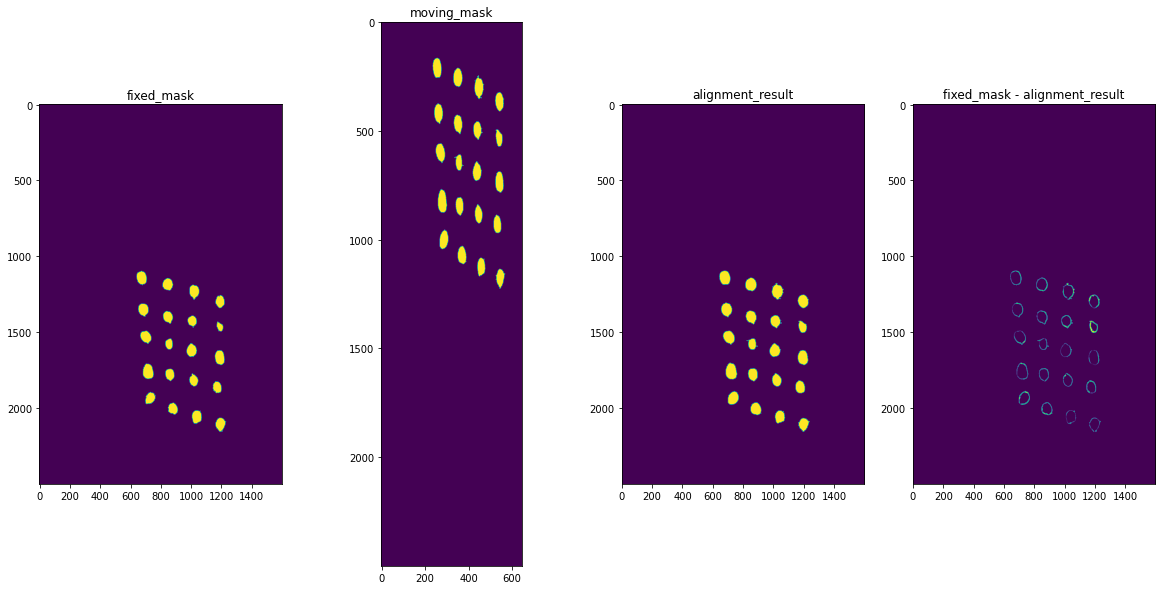

In [6]:
Alignmentresults=warp(mask_f,mask_m,H)
fig= plt.figure(figsize=(20,10))
fig.add_subplot(1,4,1)
plt.imshow(mask_f)
plt.title('fixed_mask')
fig.add_subplot(1,4,2)
plt.imshow(mask_m)
plt.title('moving_mask')
fig.add_subplot(1,4,3)
plt.imshow(Alignmentresults)
plt.title('alignment_result')
fig.add_subplot(1,4,4)
plt.imshow(abs(mask_f-Alignmentresults))
plt.title('fixed_mask - alignment_result')

# Fixing the minor difference in the alignment
To fix this difference or fine tune it, I applied image registration using the ANTsPy package. ANTsPy package has a lot image registration methods that you can apply. In my case I used the Symmetric normalization with mutual information optimization metric (SyN). To fine tune the resulted alignment from above, I took the alignment result that I acquired from the homography, which is titled "alignment_result" and used it as my "moving" image in ANTsPy. As for the fixed_mask, it will stay the same. Before apply SyNCC, we need to change the variable type of the masks from numpy to "ants"

In [7]:
fixed_mask_ants=ants.from_numpy(np.copy(mask_f))
moving_mask_ants=ants.from_numpy(np.copy(Alignmentresults))

# Building the ANTsPy Model
Here is how you build the image registration model with ANTsPy. There are other hyperparamters that you can play around with. I recommend adjusting "grad_step," which is the gradient step size, as a start.

In [8]:
mytx=ants.registration(fixed=fixed_mask_ants , moving=moving_mask_ants , type_of_transform='SyN',grad_step=0.9)

Now that we've built the model, we want to use it to warp the moving mask on to the fixed mask. 

NOTE: you can also warp from the fixed_mask to the moving_mask by changing "transformlist=mytx['fwdtransforms']"

In [9]:
warped_moving = ants.apply_transforms( fixed=fixed_mask_ants, moving=moving_mask_ants,transformlist=mytx['fwdtransforms'])

Text(0.5, 1.0, 'fixed_mask - alignment_result')

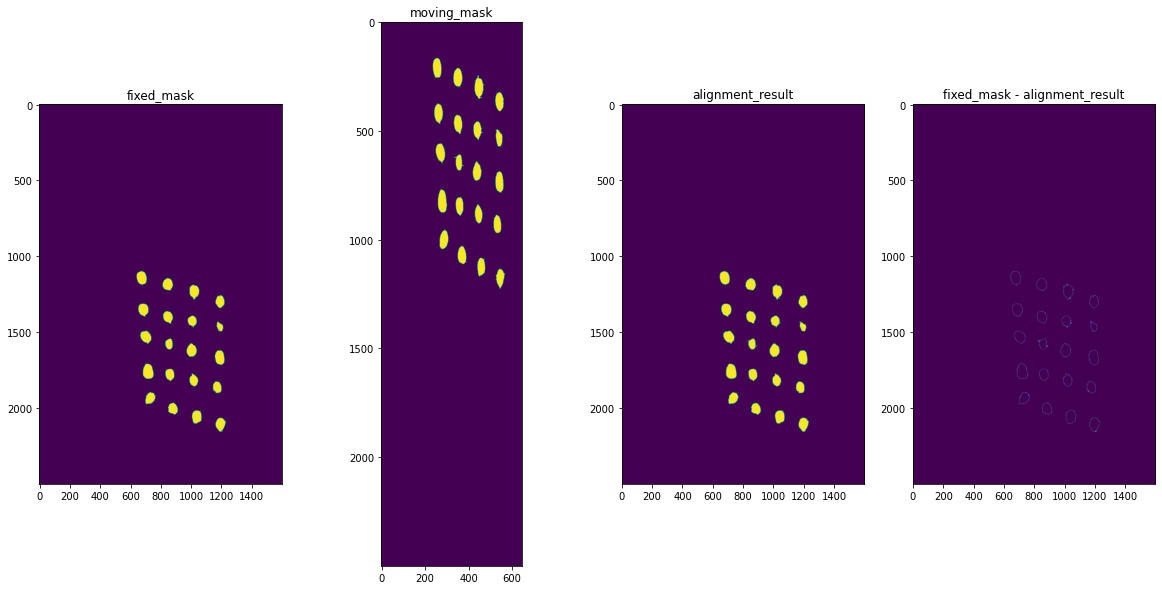

In [10]:
fig= plt.figure(figsize=(20,10))
fig.add_subplot(1,4,1)
plt.imshow(mask_f)
plt.title('fixed_mask')
fig.add_subplot(1,4,2)
plt.imshow(mask_m)
plt.title('moving_mask')
fig.add_subplot(1,4,3)
plt.imshow(warped_moving.numpy())
plt.title('alignment_result')
fig.add_subplot(1,4,4)
plt.imshow(abs(mask_f-warped_moving.numpy()))
plt.title('fixed_mask - alignment_result')

# Warping the RGB data or whatever type of data you have (HSI as well)
Now that we have built the homography and the ANTs models, we will warp the RGB data using the homography first then warp it again using the ANTs model.

In [11]:
Ants_alignment=[]
fixed_mask_ants=ants.from_numpy(np.copy(mask_f))
Homography_alignment=[]
for i in range(fixed_RGB.shape[2]):
    Homography_alignment.append(warp(mask_f,moving_RGB[:,:,i],H))
    
for i in range(fixed_RGB.shape[2]):
    temp_ants=ants.from_numpy(Homography_alignment[i])
    Ants_alignment.append(ants.apply_transforms(fixed=fixed_mask_ants, moving=temp_ants,transformlist=mytx['fwdtransforms']).numpy())
    

Mind the number of channels between the fixed and moving images. In my case, the VNIR has 372 channels and the SWIR has 270 channels. If I am warping from VNIR to SWIR, I would need to Warp 372 channels. If the opposite, I would need to warp 270 channels.

# Now let's plot the RGB alignment results after warping the data

Text(0.5, 1.0, 'Homography + ANTs model result')

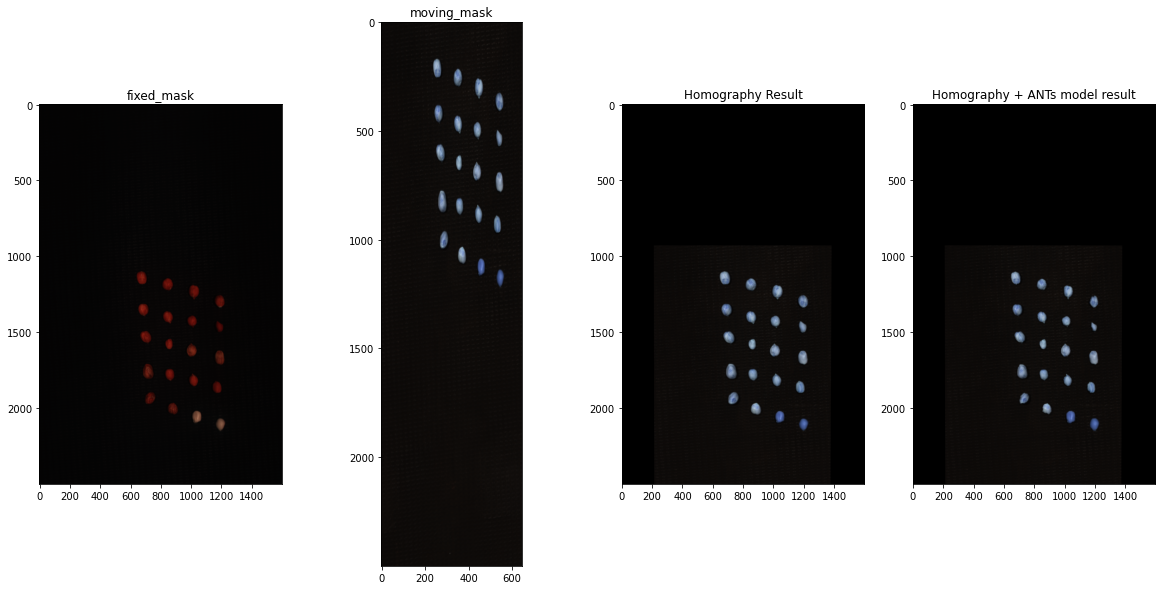

In [12]:
fig= plt.figure(figsize=(20,10))
fig.add_subplot(1,4,1)
plt.imshow(fixed_RGB)
plt.title('fixed_mask')
fig.add_subplot(1,4,2)
plt.imshow(moving_RGB)
plt.title('moving_mask')
fig.add_subplot(1,4,3)
plt.imshow(np.dstack(Homography_alignment))
plt.title('Homography Result')
fig.add_subplot(1,4,4)
plt.imshow(np.dstack(Ants_alignment).astype(np.uint8))
plt.title('Homography + ANTs model result')

and here is a closer look at the results using the masks

Text(0.5, 1.0, 'Homography + ANTs model result')

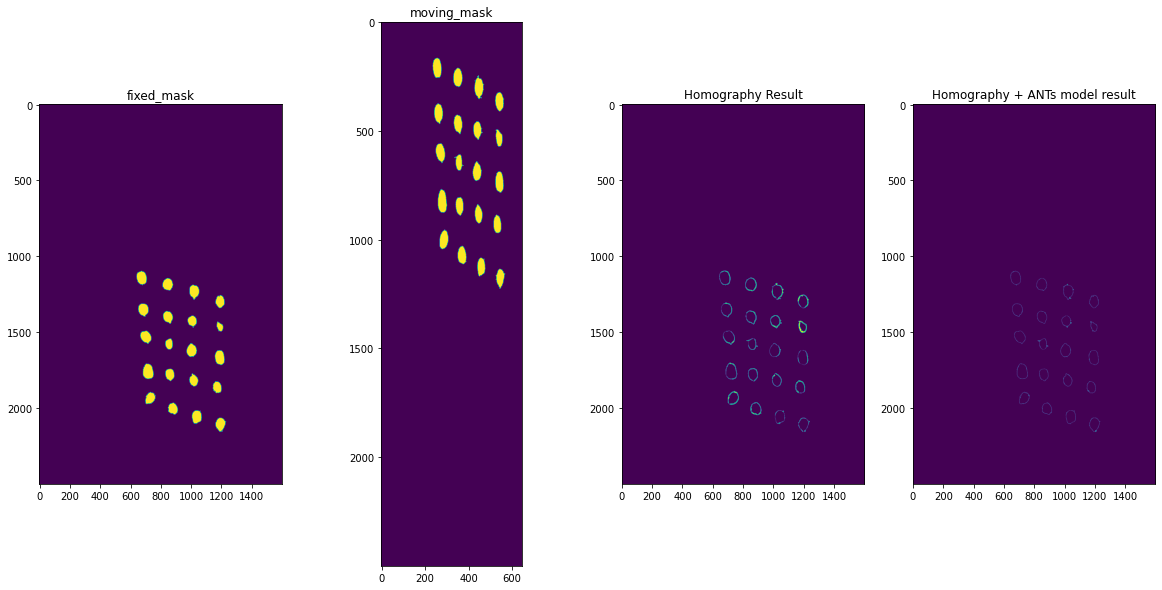

In [13]:
fig= plt.figure(figsize=(20,10))
fig.add_subplot(1,4,1)
plt.imshow(mask_f)
plt.title('fixed_mask')
fig.add_subplot(1,4,2)
plt.imshow(mask_m)
plt.title('moving_mask')
fig.add_subplot(1,4,3)
plt.imshow(abs(mask_f-Alignmentresults))
plt.title('Homography Result')
fig.add_subplot(1,4,4)
plt.imshow(abs(mask_f-warped_moving.numpy()))
plt.title('Homography + ANTs model result')